# Explicação:
Nesse arquivo há:
 - Junção e análise dos dados em catálogo usados para a tarefa de pré-treino.
Especificamente:
 - Tratamento do arquivo de 22GB dos objetos do Stripe82 do DR4
 - Selecão de objetos para o primeiro conjunto de pré-treino (filtrados, sem valores de 99 e seguindo a distribuição correta)
 - Breve análise desses dados

In [1]:
import pandas as pd
import numpy as np


### Gera CSV limpo:

In [3]:
columns = ['ID', 'RA', 'DEC', 'A', 'B', 'KRON_RADIUS', 'FWHM_n', 'e_r_iso','e_u_iso' , 'u_iso', 'e_J0378_iso', 'e_J0395_iso', 'e_J0410_iso', 'e_J0430_iso', 'e_g_iso',
'e_J0515_iso', 'J0378_iso', 'J0395_iso', 'J0410_iso', 'J0430_iso', 'g_iso', 'J0515_iso','r_iso', 
'J0660_iso', 'i_iso', 'J0861_iso', 'z_iso', 'e_J0660_iso', 'e_i_iso', 'e_J0861_iso', 'e_z_iso','SEX_FLAGS_r']
datafile = "/media/gjperin/TOSHIBA EXT/STRIPE82_iDR4.csv"
chunksize = 100000
dfs = []
for chunk in pd.read_csv(datafile, chunksize=chunksize):
    useful = chunk[columns]
    useful = useful[(useful.SEX_FLAGS_r == 0) & (useful.r_iso < 22)]
    dfs.append(useful)

final = pd.concat(dfs)

In [4]:
final['ID'] = final['ID'].str[2:30]

In [5]:
final.to_csv('./raw_tables/S82_clean.csv')

### Retira objetos com classificação

In [11]:
unl = pd.read_csv("raw_tables/S82_clean.csv")
clf = pd.read_csv("../clf/clf_90_5_5.csv")
print(f"unl possui {len(unl)} linhas")
print(f"clf possui {len(clf)} linhas")

unl possui 3179663 linhas
clf possui 133133 linhas


In [12]:
clf = clf.ID
x = pd.merge(unl,clf, indicator=True, how='outer', on="ID").query('_merge=="left_only"').drop('_merge', axis=1)
print(f"x possui {len(x)} linhas")

x possui 3046530 linhas


### Retira objetos com magnitude 99

In [8]:
x = x[(x['u_iso']!= 99) & (x['J0378_iso']!= 99) & (x['J0395_iso']!= 99) & (x['J0410_iso']!= 99) & (x['J0430_iso']!= 99) & (x['g_iso']!= 99) & (x['J0515_iso']!= 99) & 
      (x['r_iso'] != 99) & (x['J0660_iso']!= 99) & (x['i_iso']!= 99) & (x['J0861_iso']!= 99) & (x['z_iso']!= 99) ]

### Análise da distribuição:

In [6]:
print(f"Existem {len(x[x.r_iso<=14])} objetos com magnitude <= 14")
for i in range(15,23):
    c = len(x[(x.r_iso>i-1)&(x.r_iso<=i)])
    print(f"Existem {c} objetos com magnitude {i-1}<r<={i} ({c/len(x)*100}%)")

Existem 17648 objetos com magnitude <= 14
Existem 25165 objetos com magnitude 14<r<=15 (2.1083242152744384%)
Existem 44332 objetos com magnitude 15<r<=16 (3.714135867734806%)
Existem 74477 objetos com magnitude 16<r<=17 (6.239684584978913%)
Existem 120550 objetos com magnitude 17<r<=18 (10.099681468362151%)
Existem 182653 objetos com magnitude 18<r<=19 (15.302672079973057%)
Existem 238015 objetos com magnitude 19<r<=20 (19.940901573556342%)
Existem 265689 objetos com magnitude 20<r<=21 (22.25942986020466%)
Existem 225073 objetos com magnitude 21<r<=22 (18.856620548558062%)


### Retirar objetos com erro maior que 0.05

In [9]:
x = x[(x['e_u_iso']< 0.05) & (x['e_J0378_iso']< 0.05) & (x['e_J0395_iso']< 0.05) & (x['e_J0410_iso']< 0.05) & (x['e_J0430_iso']< 0.05) & (x['e_g_iso']< 0.05) & (x['e_J0515_iso']< 0.05) & 
      (x['e_r_iso'] < 0.05) & (x['e_J0660_iso']< 0.05) & (x['e_i_iso']< 0.05) & (x['e_J0861_iso']< 0.05) & (x['e_z_iso']< 0.05)]

In [15]:
small_noise = x[x.e_r_iso < 0.05].sample(n=120000, axis = 'index', random_state=2)


In [20]:
small_noise.to_csv("unl_small_noise.csv")

### Podar os dados para a distribuição desejada:

In [17]:
p = {(19,20):238015, (20,21):190412, (18,19):174733, (21,22):155843, (17,18):104839, (16,17):51947, (15,16):23612, (14,15):1889}
datafs = []
for key in p.keys():
    t = x[(x.r_iso > key[0]) & (x.r_iso <= key[1])]
    datafs.append(t.sample(n = p[key], axis='index', random_state=2))
final_b = pd.concat(datafs).reset_index(drop=True)

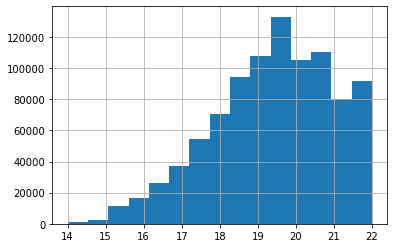

In [18]:
final_b.r_iso.hist(bins=15)

In [8]:
p = {(19,20):238015//8, (20,21):190412//8, (18,19):174733//8, (21,22):155843//8, (17,18):104839//8, (16,17):51947//8, (15,16):23612//8, (14,15):1889//8}
datafs = []
for key in p.keys():
    t = x[(x.r_iso > key[0]) & (x.r_iso <= key[1])]
    datafs.append(t.sample(n = p[key], axis='index', random_state=2))
final_s = pd.concat(datafs).reset_index(drop=True)

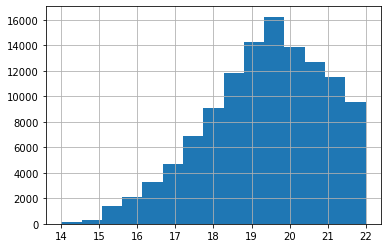

In [9]:
final_s.r_iso.hist(bins=15)

### Retira objetos sem imagem

In [10]:
IDS = ['iDR4_3_STRIPE82-0074_0050444',
'iDR4_3_STRIPE82-0088_0134958',
'iDR4_3_STRIPE82-0119_0007873',
'iDR4_3_STRIPE82-0121_0000836',
'iDR4_3_STRIPE82-0134_0029763',
'iDR4_3_STRIPE82-0087_0139570',
'iDR4_3_STRIPE82-0042_0044839',
'iDR4_3_STRIPE82-0130_0029840',
'iDR4_3_STRIPE82-0158_0030865',
'iDR4_3_STRIPE82-0087_0139219',
'iDR4_3_STRIPE82-0110_0066277',
'iDR4_3_STRIPE82-0088_0132786',
'iDR4_3_STRIPE82-0110_0074857',
'iDR4_3_STRIPE82-0088_0137405',
'iDR4_3_STRIPE82-0042_0044898',
'iDR4_3_STRIPE82-0121_0002535',
'iDR4_3_STRIPE82-0110_0074358',
'iDR4_3_STRIPE82-0119_0000975',
'iDR4_3_STRIPE82-0088_0136078',
'iDR4_3_STRIPE82-0034_0030830',
'iDR4_3_STRIPE82-0092_0104473',
'iDR4_3_STRIPE82-0119_0005304',
'iDR4_3_STRIPE82-0121_0003994',
'iDR4_3_STRIPE82-0121_0002900',
'iDR4_3_STRIPE82-0119_0003104',
'iDR4_3_STRIPE82-0036_0013965',
'iDR4_3_STRIPE82-0088_0138553']
final_s = final_s[~(final_s.ID.isin(IDS))]

### Train/Test/Val Split

In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(final_b, test_size=0.25,random_state=2)
train, val = train_test_split(train, test_size=0.2,random_state=2)
train = train.assign(split="train")
test = test.assign(split="test")
val = val.assign(split="val")
final_b = pd.concat([train,test,val])    

In [20]:
#final_s.to_csv("unl_small.csv")
final_b.to_csv("unl_big_w99.csv")

In [2]:
import pandas as pd
final_s = pd.read_csv("unl_small.csv")

In [15]:
final_s[ ['u_iso', 'J0378_iso', 'J0395_iso', 'J0410_iso', 'J0430_iso', 'g_iso', 'J0515_iso', 'r_iso', 
'J0660_iso', 'i_iso', 'J0861_iso', 'z_iso']].max().max()

36.972713

In [21]:
smn = pd.read_csv("unl_small_noise.csv")
from sklearn.model_selection import train_test_split
train, test = train_test_split(smn, test_size=0.1,random_state=2)
test, val = train_test_split(test, test_size=0.5,random_state=2)
train = train.assign(split="train")
test = test.assign(split="test")
val = val.assign(split="val")
smn = pd.concat([train,test,val])   
smn.to_csv("unl_small_noise.csv")

In [7]:
smn = pd.read_csv("unl_small_noise.csv")
smn[smn.split =="val"]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,ID,RA,DEC,A,B,KRON_RADIUS,...,J0430_iso,g_iso,J0515_iso,r_iso,J0660_iso,i_iso,J0861_iso,z_iso,SEX_FLAGS_r,split
105984,114000,105920,3099419,9231791,iDR4_3_STRIPE82-0164_0057541,355.023389,1.077231,0.000209,0.000194,3.557383,...,20.188396,19.856241,19.742489,19.171352,19.094145,18.813960,18.641018,18.708643,0.0,val
105985,114001,27526,1941928,5957682,iDR4_3_STRIPE82-0104_0027314,312.507114,0.439849,0.000252,0.000237,3.818191,...,18.978998,18.611868,18.448587,18.088337,17.976402,17.867529,17.861181,17.795359,0.0,val
105986,114002,42183,64691,208484,iDR4_3_STRIPE82-0005_0033540,2.267893,-0.041635,0.000554,0.000401,4.272223,...,20.250051,19.548360,19.302013,18.456608,18.301733,17.994484,17.828642,17.658915,0.0,val
105987,114003,116124,1803746,5586461,iDR4_3_STRIPE82-0100_0047124,308.317611,0.651317,0.000256,0.000208,3.816561,...,20.826345,20.317255,20.084782,19.635654,19.442486,19.275942,19.361988,19.095644,0.0,val
105988,114004,20913,1754866,5443141,iDR4_3_STRIPE82-0099_0010843,308.483248,-1.227141,0.000291,0.000280,3.990332,...,19.799902,19.258066,19.077309,18.482850,18.403728,18.092080,18.058111,17.934353,0.0,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111558,119994,9132,2956541,8763527,iDR4_3_STRIPE82-0154_0026015,346.831619,0.749367,0.000263,0.000258,3.227543,...,18.273840,17.819225,17.650726,17.236702,17.163220,17.026743,16.956928,16.943758,0.0,val
111559,119995,24622,612368,2097839,iDR4_3_STRIPE82-0045_0019526,31.306842,-0.824247,0.000327,0.000292,3.165165,...,19.755163,18.538303,18.458021,17.245150,16.805468,15.992848,15.619257,15.463009,0.0,val
111560,119997,101853,1497148,4909140,iDR4_3_STRIPE82-0093_0082529,303.980209,-0.388334,0.000344,0.000336,3.551454,...,18.264805,17.646732,17.422867,16.906826,16.819118,16.639856,16.559130,16.540382,0.0,val
111561,119998,26509,1319794,4520430,iDR4_3_STRIPE82-0090_0090868,301.518666,0.851219,0.000337,0.000318,3.214367,...,16.919987,16.599325,16.429472,16.073507,16.023457,15.877115,15.812462,15.809920,0.0,val
